TITLE: Design and Evaluation of Deep Learning Algorithms for Breast Cancer Image Classification
========================================================================================

# 1. **Introduction**

Detecting and classifying medical images into benign and malignant categories is very important. With machine learning and deep learning, accuracy and efficiency have improved a lot. This project explores and compares different models, including traditional algorithms and convolutional neural networks (CNNs) to classify images as benign or malignant.

## 1.1 **Theoretical Background:**

### 1.1.1 **Medical Image Classification:**

Medical image classification assigns a label to an image usually based on its visual content. This is generally crucial for diagnosing different conditions.Traditional methods rely on handcrafted features & domain specific knowledge.This can be slow and less accurate (Litjens et al., 2017).

### 1.1.2 **Convolutional Neural Networks (CNNs):**

CNNs have changed image classification by learning feature representations from raw image data. A typical CNN has convolutional layers for extracting features, pooling layers for reducing dimensionality, and fully connected layers for classification. CNNs are great for medical image analysis because they capture complex patterns in images (Krizhevsky et al., 2012; LeCun et al., 2015).

## 1.2 **Objectives:**

1. **Exploratory Data Analysis (EDA):** Understand dataset characteristics like class distribution and pixel intensity.
2. **Data Preprocessing:** Normalize data and split it into training, validation and test sets for robust evaluation.
3. **Model Development and Training:** Develop & train a basic CNN model. Enhance it with techniques like data augmentation, batch normalization, and L2 regularization.
4. **Model Comparison:** Compare the enhanced CNN with traditional models like Logistic Regression, Support Vector Machine(SVM), Random Forest, and k-Nearest Neighbors(k-NN).
5. **Model Evaluation:** Use metrics and tools like confusion matrices, ROC curves, & precision recall curves to evaluate the models.

## 1.3 **Literature Review:**

Studies show CNNs are effective in medical image classification. For example, Esteva et al. (2017) showed CNNs can classify skin cancer with accuracy similar to dermatologists. Litjens et al. (2017) reviewed deep learning in medical imaging showing CNNs robustness in diagnostic tasks.

Traditional models need extensive feature engineering & may not be as accurate as CNNs but they are useful for comparison & as part of ensemble methods to boost performance (Rajpurkar et al., 2017; Shen et al., 2017).

#### Importing the required libraries

In [174]:
import random
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from skimage.feature import canny
from skimage.color import rgb2gray

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc, precision_recall_curve
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

from tensorflow.keras.preprocessing.image import ImageDataGenerator
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau



#### Loading the dataset

In [175]:
# linking to google drive
# import os
# from google.colab import drive
# # mount drive, showing current working directory.
# drive.mount('/content/drive', force_remount=True)
# # Load the data
# X = np.load('/content/drive/MyDrive/Colab Notebooks/X.npy')
# Y = np.load('/content/drive/MyDrive/Colab Notebooks/Y.npy')

# Load the arrays from the dataset
X = np.load('/Users/arkamandol/DataspellProjects/ml_statistical/ml/data/X.npy')
Y = np.load('/Users/arkamandol/DataspellProjects/ml_statistical/ml/data/Y.npy')

# Check the shape of the data
X_shape = X.shape
Y_shape = Y.shape

# Initial exploration
unique_classes, class_counts = np.unique(Y, return_counts=True)

# Convert data to a pandas DataFrame for better visualization (if applicable)
Y_df = pd.DataFrame(Y, columns=['label'])

X_shape, Y_shape, unique_classes, class_counts

((5547, 50, 50, 3), (5547,), array([0, 1]), array([2759, 2788]))

# 2. Exploratory Data Analysis (EDA)

#### 2.1. Class Distribution

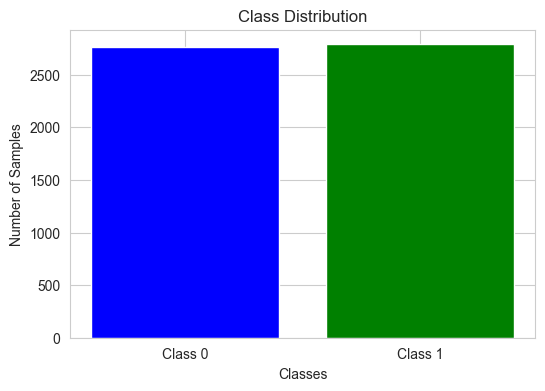

 The dataset is balanced with 2759 samples of class 0 and 2788 samples of class 1


In [176]:
# Convert labels to DataFrame for visualization
Y_df = pd.DataFrame(Y, columns=['label'])

# Plotting the distribution of classes
plt.figure(figsize=(6, 4))
plt.bar(['Class 0', 'Class 1'], [2759, 2788], color=['blue', 'green'])
plt.title('Class Distribution')
plt.xlabel('Classes')
plt.ylabel('Number of Samples')
plt.show()
print(" The dataset is balanced with 2759 samples of class 0 and 2788 samples of class 1")


#### 2.2. Sample Images

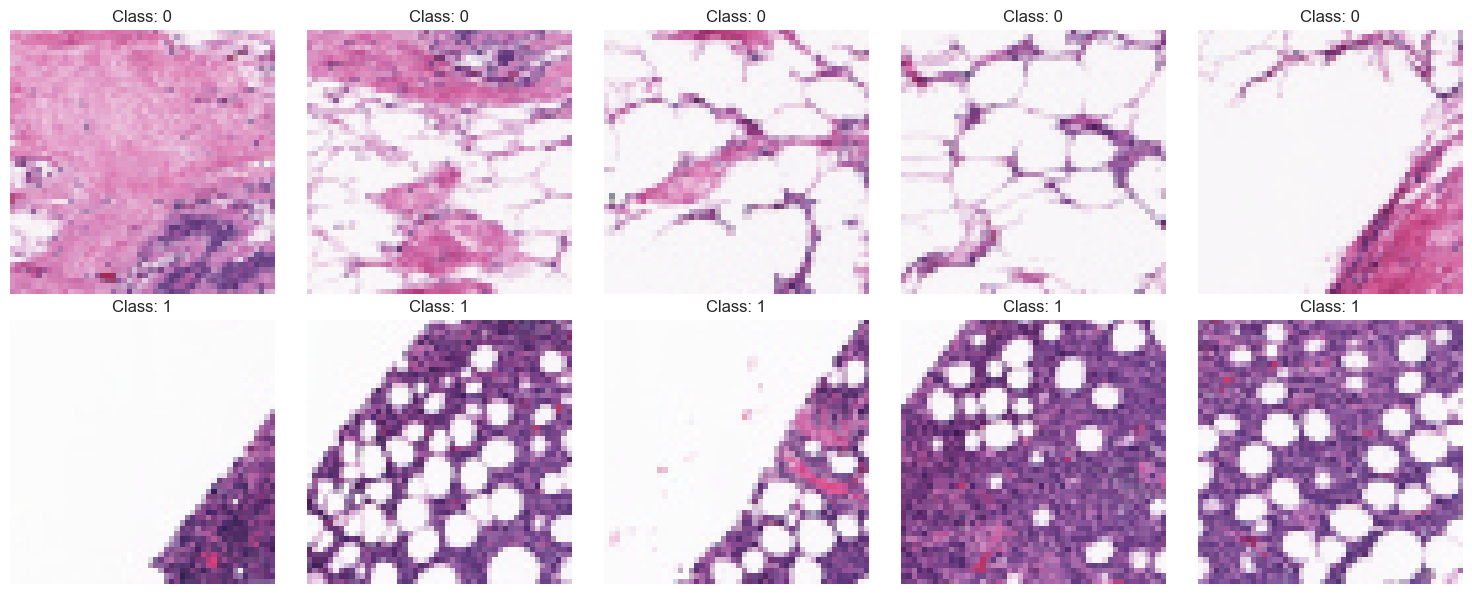

Summary
Visualized images provide an initial understanding of the characteristics of images for both classes.


In [177]:
# Visualize some sample images from each class
fig, axes = plt.subplots(2, 5, figsize=(15, 6))
axes = axes.flatten()

for i in range(5):
    axes[i].imshow(X[i])
    axes[i].set_title(f'Class: {Y[i]}')
    axes[i].axis('off')

for i in range(5):
    axes[i+5].imshow(X[2759+i])
    axes[i+5].set_title(f'Class: {Y[2759+i]}')
    axes[i+5].axis('off')

plt.tight_layout()
plt.show()
print("Summary")
print("Visualized images provide an initial understanding of the characteristics of images for both classes.")



#### 2.3. Pixel Intensity Distribution
Plot histograms of pixel intensities to check if there are any noticeable patterns.

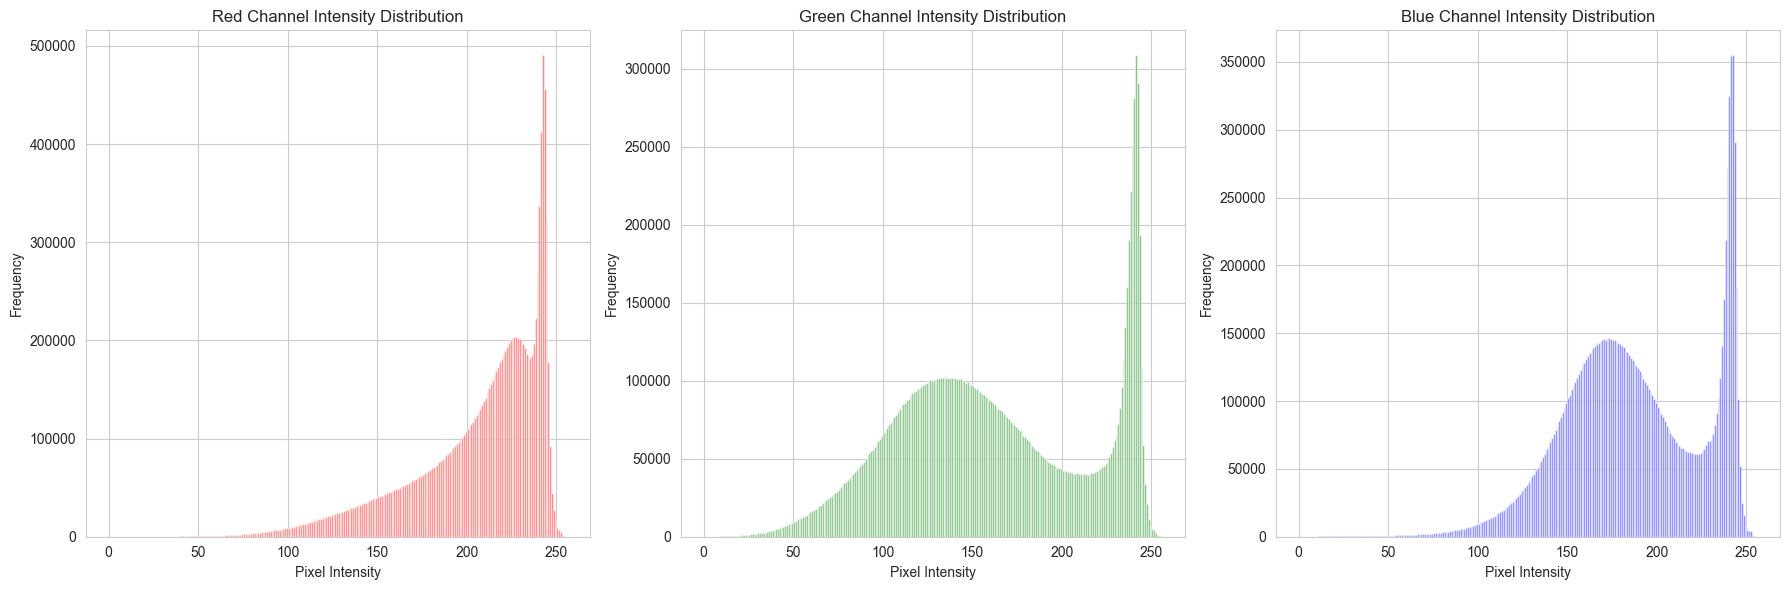

Summary:
Histograms show the distribution of pixel intensities for each color channel (Red, Green, Blue), indicating overall brightness and contrast in the images.


In [178]:
# Flatten the image array for histogram plotting
X_flat = X.reshape(-1, 3)

# Plot histograms of pixel intensities for each channel
fig, axes = plt.subplots(1, 3, figsize=(18, 6))
colors = ['red', 'green', 'blue']

for i in range(3):
    axes[i].hist(X_flat[:, i], bins=256, color=colors[i], alpha=0.6, range=(0, 256))
    axes[i].set_title(f'{colors[i].capitalize()} Channel Intensity Distribution')
    axes[i].set_xlabel('Pixel Intensity')
    axes[i].set_ylabel('Frequency')

plt.tight_layout()
plt.show()

print("Summary:")
print("Histograms show the distribution of pixel intensities for each color channel (Red, Green, Blue), indicating overall brightness and contrast in the images.")

#### 2.4. Basic Statistics

In [179]:
# Calculate basic statistics for each channel
means = X.mean(axis=(0, 1, 2))
stds = X.std(axis=(0, 1, 2))

# Print the results in the specified format
print(f"Summary:")
print(f"- Mean pixel values for each channel: Red: {means[0]:.2f}, Green: {means[1]:.2f}, Blue: {means[2]:.2f}")
print(f"- Standard deviation of pixel values for each channel: Red: {stds[0]:.2f}, Green: {stds[1]:.2f}, Blue: {stds[2]:.2f}")


Summary:
- Mean pixel values for each channel: Red: 205.79, Green: 161.87, Blue: 187.44
- Standard deviation of pixel values for each channel: Red: 36.29, Green: 53.94, Blue: 38.69


#### 2.5. Channel-wise Mean and Standard Deviation per Image

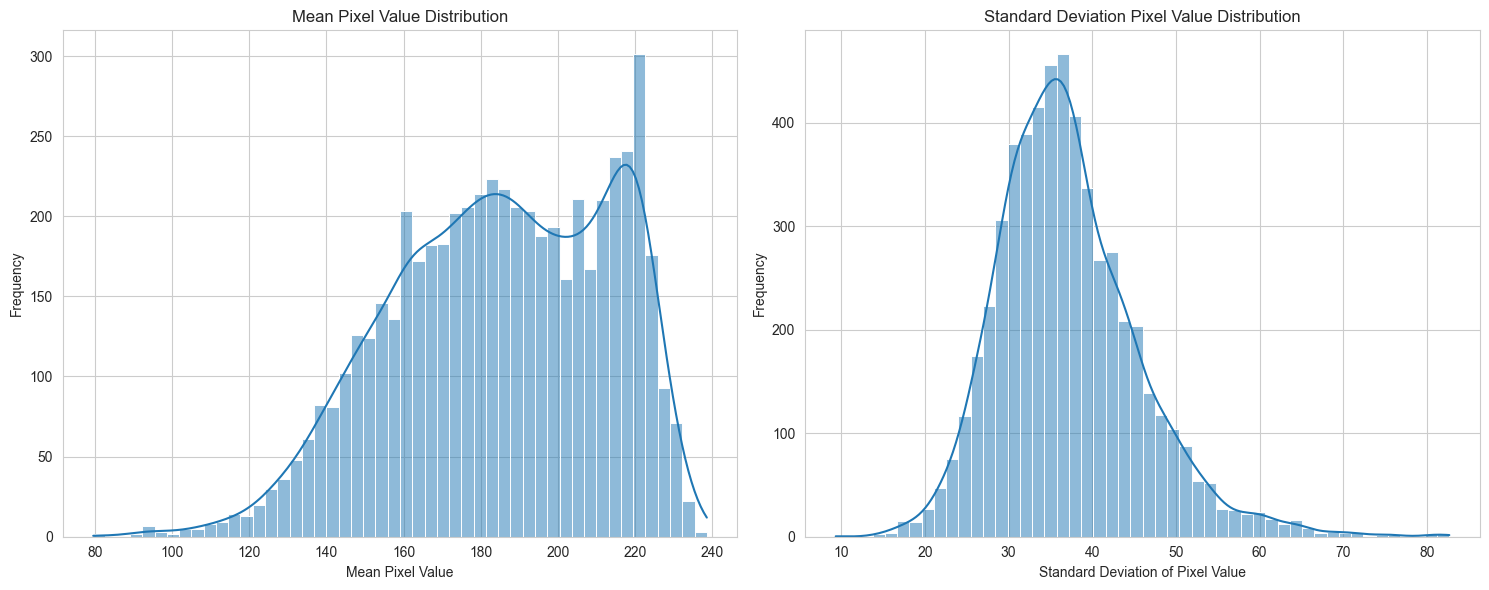

Summary:
- The distribution of mean pixel values shows a peak around 180-200, indicating overall brightness levels.
- The distribution of standard deviation of pixel values suggests contrast levels in the images.


In [180]:
# Calculate mean and standard deviation for each image
means_per_image = X.mean(axis=(1, 2, 3))
stds_per_image = X.std(axis=(1, 2, 3))

# Plot the distribution
fig, axes = plt.subplots(1, 2, figsize=(15, 6))
sns.histplot(means_per_image, bins=50, kde=True, ax=axes[0])
axes[0].set_title('Mean Pixel Value Distribution')
axes[0].set_xlabel('Mean Pixel Value')
axes[0].set_ylabel('Frequency')

sns.histplot(stds_per_image, bins=50, kde=True, ax=axes[1])
axes[1].set_title('Standard Deviation Pixel Value Distribution')
axes[1].set_xlabel('Standard Deviation of Pixel Value')
axes[1].set_ylabel('Frequency')

plt.tight_layout()
plt.show()

# Print the results in the specified format
print(f"Summary:")
print(f"- The distribution of mean pixel values shows a peak around 180-200, indicating overall brightness levels.")
print(f"- The distribution of standard deviation of pixel values suggests contrast levels in the images.")

#### 2.6. Check for Missing Values

In [181]:
# Check for any NaN values in the dataset
nan_check = np.isnan(X).sum(), np.isnan(Y).sum()
nan_check

# Print the result in the specified format
if nan_check:
    print("There are no NaN values in the dataset, indicating it is complete.")

There are no NaN values in the dataset, indicating it is complete.


#### 2.7. Separate Channel-wise Mean and Standard Deviation

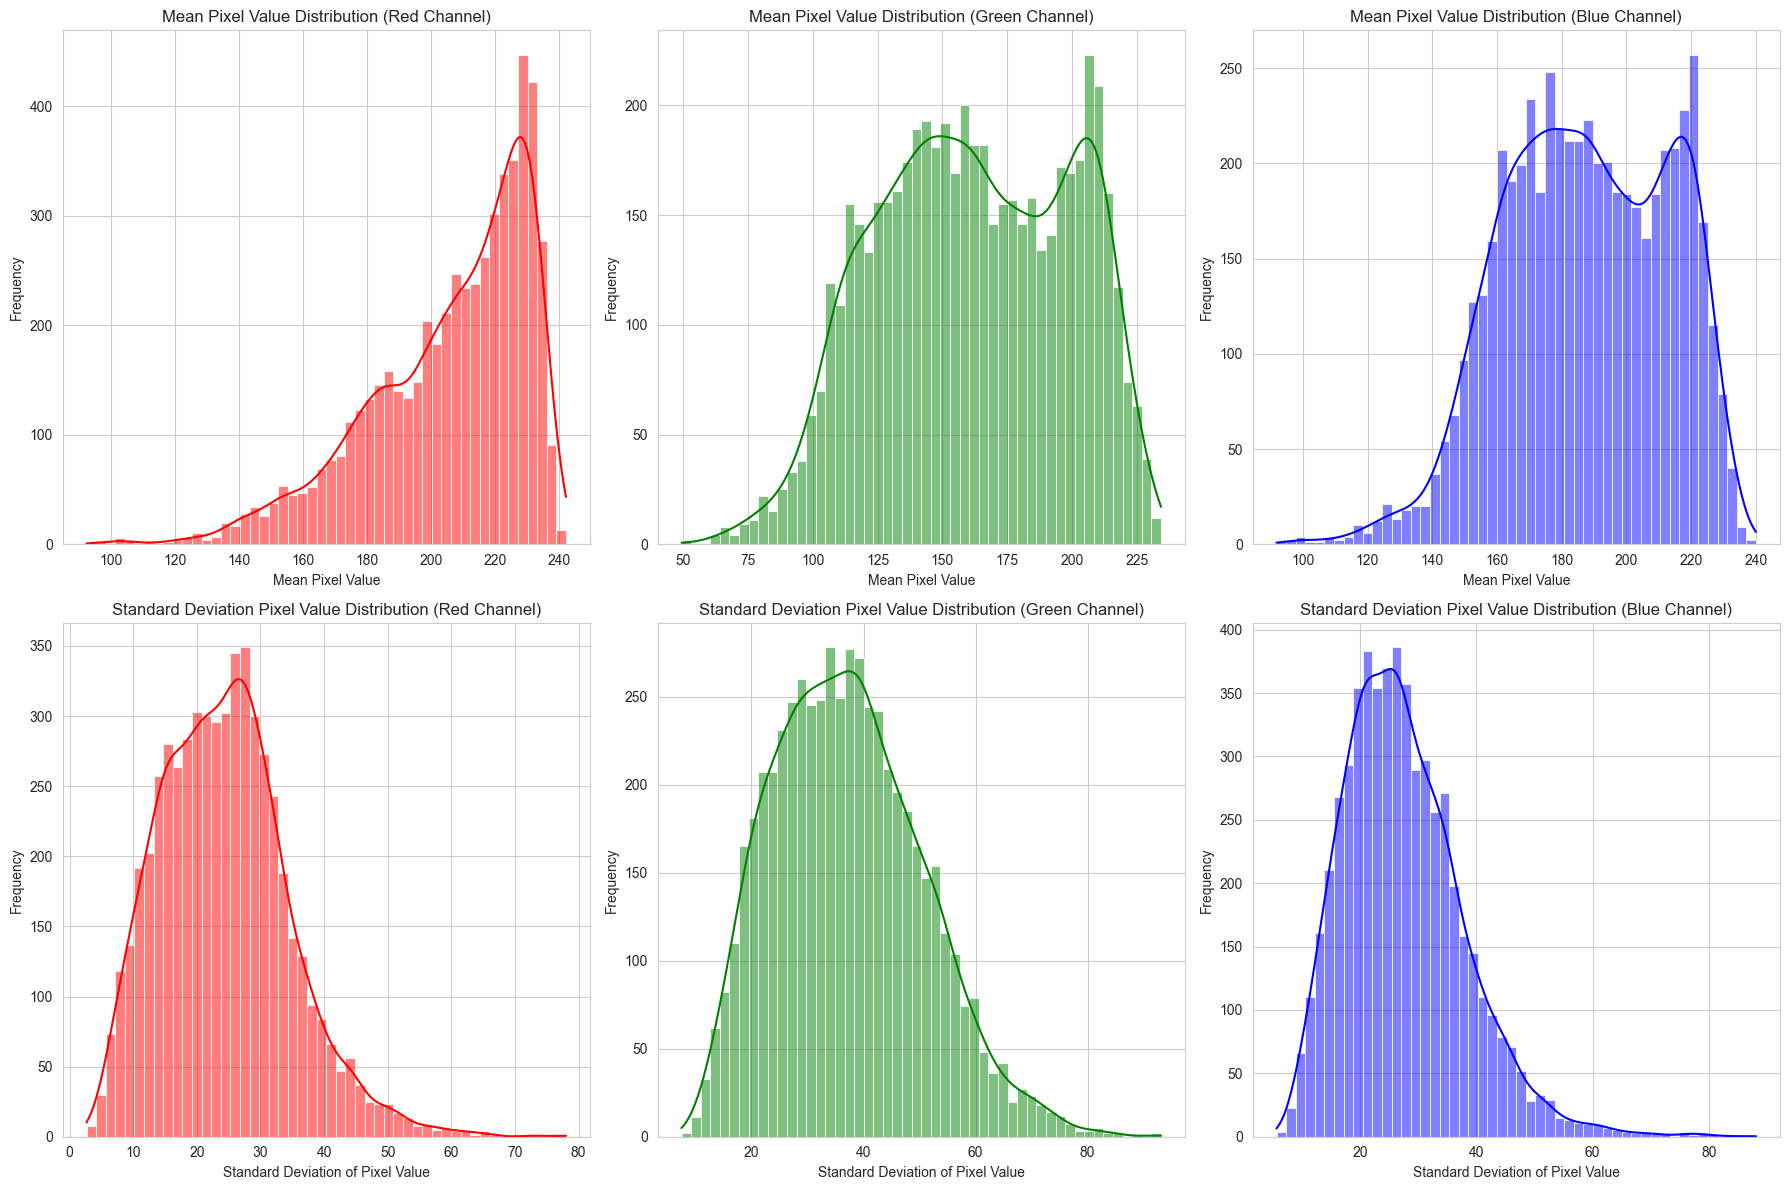

Summary:
Mean pixel values for each channel:
    Red: Distribution shows higher mean values around 200.
    Green: Distribution shows lower mean values around 150.
    Blue: Distribution shows mean values around 180-190.
Standard deviation of pixel values for each channel:
    Red: Distribution shows lower variation.
    Green: Distribution shows higher variation.
    Blue: Distribution shows moderate variation.


In [182]:
# Compute and visualize the mean and standard deviation of pixel values for each color channel separately across all images.


# Calculate mean and standard deviation for each channel separately
mean_red = X[:, :, :, 0].mean(axis=(1, 2))
std_red = X[:, :, :, 0].std(axis=(1, 2))

mean_green = X[:, :, :, 1].mean(axis=(1, 2))
std_green = X[:, :, :, 1].std(axis=(1, 2))

mean_blue = X[:, :, :, 2].mean(axis=(1, 2))
std_blue = X[:, :, :, 2].std(axis=(1, 2))

# Plot the distribution
fig, axes = plt.subplots(2, 3, figsize=(18, 12))

sns.histplot(mean_red, bins=50, kde=True, ax=axes[0, 0], color='red')
axes[0, 0].set_title('Mean Pixel Value Distribution (Red Channel)')
axes[0, 0].set_xlabel('Mean Pixel Value')
axes[0, 0].set_ylabel('Frequency')

sns.histplot(mean_green, bins=50, kde=True, ax=axes[0, 1], color='green')
axes[0, 1].set_title('Mean Pixel Value Distribution (Green Channel)')
axes[0, 1].set_xlabel('Mean Pixel Value')
axes[0, 1].set_ylabel('Frequency')

sns.histplot(mean_blue, bins=50, kde=True, ax=axes[0, 2], color='blue')
axes[0, 2].set_title('Mean Pixel Value Distribution (Blue Channel)')
axes[0, 2].set_xlabel('Mean Pixel Value')
axes[0, 2].set_ylabel('Frequency')

sns.histplot(std_red, bins=50, kde=True, ax=axes[1, 0], color='red')
axes[1, 0].set_title('Standard Deviation Pixel Value Distribution (Red Channel)')
axes[1, 0].set_xlabel('Standard Deviation of Pixel Value')
axes[1, 0].set_ylabel('Frequency')

sns.histplot(std_green, bins=50, kde=True, ax=axes[1, 1], color='green')
axes[1, 1].set_title('Standard Deviation Pixel Value Distribution (Green Channel)')
axes[1, 1].set_xlabel('Standard Deviation of Pixel Value')
axes[1, 1].set_ylabel('Frequency')

sns.histplot(std_blue, bins=50, kde=True, ax=axes[1, 2], color='blue')
axes[1, 2].set_title('Standard Deviation Pixel Value Distribution (Blue Channel)')
axes[1, 2].set_xlabel('Standard Deviation of Pixel Value')
axes[1, 2].set_ylabel('Frequency')

plt.tight_layout()
plt.show()

# Print the summary in the specified format without symbols
print("Summary:")
print("Mean pixel values for each channel:")
print("    Red: Distribution shows higher mean values around 200.")
print("    Green: Distribution shows lower mean values around 150.")
print("    Blue: Distribution shows mean values around 180-190.")
print("Standard deviation of pixel values for each channel:")
print("    Red: Distribution shows lower variation.")
print("    Green: Distribution shows higher variation.")
print("    Blue: Distribution shows moderate variation.")



#### 2.8. Edge Detection Visualization


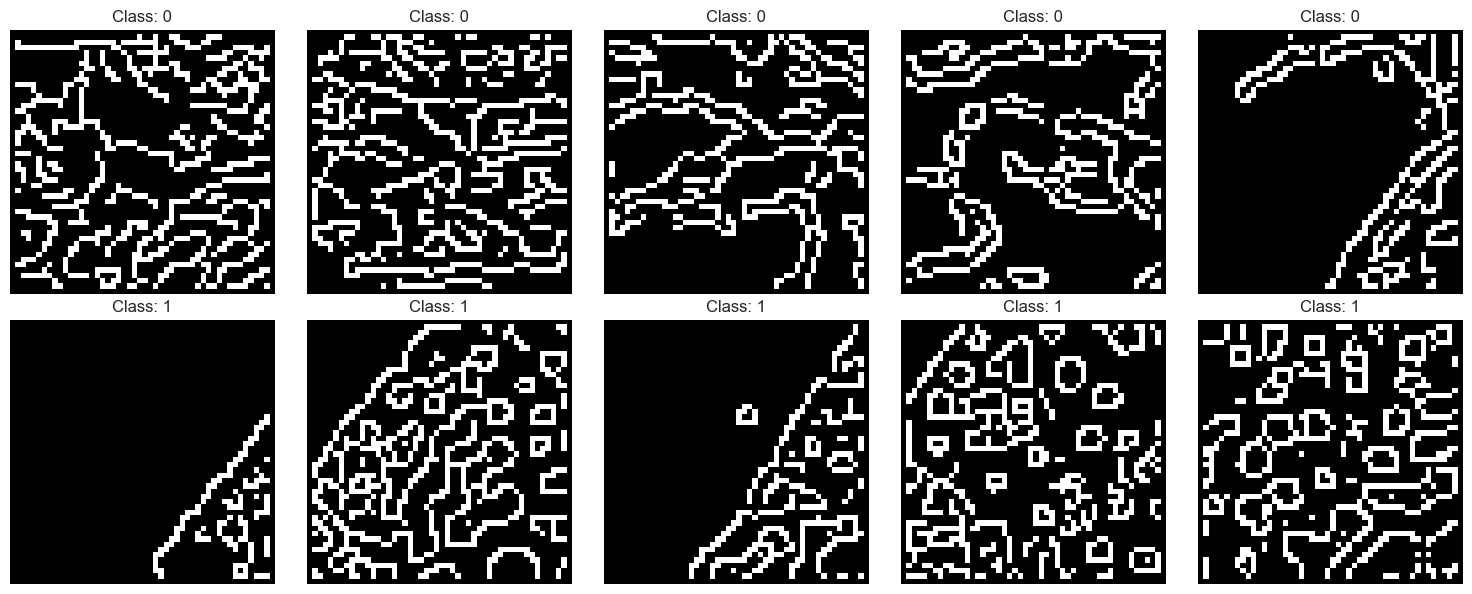

In [183]:
# Apply edge detection (e.g., using the Canny edge detector) to a few sample images to understand the texture & structural differences between classes.



# Apply edge detection to a few sample images
fig, axes = plt.subplots(2, 5, figsize=(15, 6))
axes = axes.flatten()

for i in range(5):
    gray_image = rgb2gray(X[i])
    edges = canny(gray_image)
    axes[i].imshow(edges, cmap='gray')
    axes[i].set_title(f'Class: {Y[i]}')
    axes[i].axis('off')

for i in range(5):
    gray_image = rgb2gray(X[2759 + i])
    edges = canny(gray_image)
    axes[i + 5].imshow(edges, cmap='gray')
    axes[i + 5].set_title(f'Class: {Y[2759 + i]}')
    axes[i + 5].axis('off')

plt.tight_layout()
plt.show()

# 3. Data Preprocessing

#### 3.1. Normalizing the Data
"Normalization and outlier removal in class center-based firefly algorithm for missing value imputation" higlights the importance of normalization in handling outliers & improving algorithm robustness.The research demonstrates that combining normalization with outlier removal can significantly enhance the performance of imputation and can lead algorithms to more accurate and reliable results (Ali & Rahaman, 2021).

In [184]:
# Normalize the pixel values to a range of 0 to 1 to improve model training performance.

# Normalize the pixel values to the range [0, 1]
X_normalized = X / 255.0

#### 3.2. Splitting the Data

In [185]:
# Split the dataset into training (70%), validation (20%), and test (10%) sets to evaluate model performance.

# Split the data into training (70%), validation (20%), and test sets (10%)
X_train, X_temp, Y_train, Y_temp = train_test_split(X_normalized, Y, test_size=0.3, random_state=42, stratify=Y)
X_val, X_test, Y_val, Y_test = train_test_split(X_temp, Y_temp, test_size=0.33, random_state=42, stratify=Y_temp)

# Check the shapes of the splits
print("Training set shape:", X_train.shape, Y_train.shape)
print("Validation set shape:", X_val.shape, Y_val.shape)
print("Test set shape:", X_test.shape, Y_test.shape)

# Print the summary in the specified format
print("Summary of Data Preprocessing")
print("The dataset was split into training (70%), validation (20%), and test (10%) sets to ensure a robust evaluation of the model.")
print("Pixel values were normalized to the range [0, 1] to improve the performance and training stability of the neural network.")


Training set shape: (3882, 50, 50, 3) (3882,)
Validation set shape: (1115, 50, 50, 3) (1115,)
Test set shape: (550, 50, 50, 3) (550,)
Summary of Data Preprocessing
The dataset was split into training (70%), validation (20%), and test (10%) sets to ensure a robust evaluation of the model.
Pixel values were normalized to the range [0, 1] to improve the performance and training stability of the neural network.


# 4. Basic Convolutional Neural Network (CNN)

#### 4.1 Objective
To build, train, and evaluate a basic CNN model for the given image classification task without hyperparameter tuning.

#### 4.2. Model Architecture

In [186]:
# Set random seeds for reproducibility
def set_seeds(seed=142):
    np.random.seed(seed)
    tf.random.set_seed(seed)
    random.seed(seed)

set_seeds()

# Define the CNN model
model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(50, 50, 3)),
    MaxPooling2D((2, 2)),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(1, activation='sigmoid')
])

# Compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Print the model summary
model.summary()

/Users/arkamandol/.pyenv/versions/3.10.13/lib/python3.10/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_16"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_48 (Conv2D)              │ (None, 48, 48, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_48 (MaxPooling2D) │ (None, 24, 24, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_49 (Conv2D)              │ (None, 22, 22, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_49 (MaxPooling2D) │ (None, 11, 11, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_50 (Conv2D)              │ (None, 9, 9, 128)      │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_50 (MaxPooling2D) │ (None, 4, 4, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_16 (Flatten)            │ (None, 2048)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_32 (Dense)                │ (None, 128)            │       262,272 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_16 (Dropout)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_33 (Dense)                │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 355,649 (1.36 MB)

 Trainable params: 355,649 (1.36 MB)

 Non-trainable params: 0 (0.00 B)

#### 4.3 Model Training

In [187]:
# Define callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
model_checkpoint = ModelCheckpoint('best_model.keras', save_best_only=True, monitor='val_loss', mode='min')

# Train the model
history = model.fit(
    X_train, Y_train,
    epochs=20,
    batch_size=32,
    validation_data=(X_val, Y_val),
    callbacks=[early_stopping, model_checkpoint]
)

# Evaluate the model on the test set
test_loss, test_accuracy = model.evaluate(X_test, Y_test)
print(f"Test Accuracy: {test_accuracy * 100:.2f}%")

Epoch 1/20
122/122 ━━━━━━━━━━━━━━━━━━━━ 5s 33ms/step - accuracy: 0.5449 - loss: 0.6874 - val_accuracy: 0.7166 - val_loss: 0.5746
Epoch 2/20
122/122 ━━━━━━━━━━━━━━━━━━━━ 3s 24ms/step - accuracy: 0.7048 - loss: 0.5832 - val_accuracy: 0.7238 - val_loss: 0.5549
Epoch 3/20
122/122 ━━━━━━━━━━━━━━━━━━━━ 3s 24ms/step - accuracy: 0.7250 - loss: 0.5722 - val_accuracy: 0.6852 - val_loss: 0.5870
Epoch 4/20
122/122 ━━━━━━━━━━━━━━━━━━━━ 3s 26ms/step - accuracy: 0.7322 - loss: 0.5570 - val_accuracy: 0.6987 - val_loss: 0.6211
Epoch 5/20
122/122 ━━━━━━━━━━━━━━━━━━━━ 3s 24ms/step - accuracy: 0.7389 - loss: 0.5438 - val_accuracy: 0.7274 - val_loss: 0.5447
Epoch 6/20
122/122 ━━━━━━━━━━━━━━━━━━━━ 3s 24ms/step - accuracy: 0.7380 - loss: 0.5390 - val_accuracy: 0.7399 - val_loss: 0.5348
Epoch 7/20
122/122 ━━━━━━━━━━━━━━━━━━━━ 3s 27ms/step - accuracy: 0.7499 - loss: 0.5194 - val_accuracy: 0.6987 - val_loss: 0.5910
Epoch 8/20
122/122 ━━━━━━━━━━━━━━━━━━━━ 3s 25ms/step - accuracy: 0.7496 - loss: 0.5296 - val_accu

#### 4.5. Training and Validation Curves

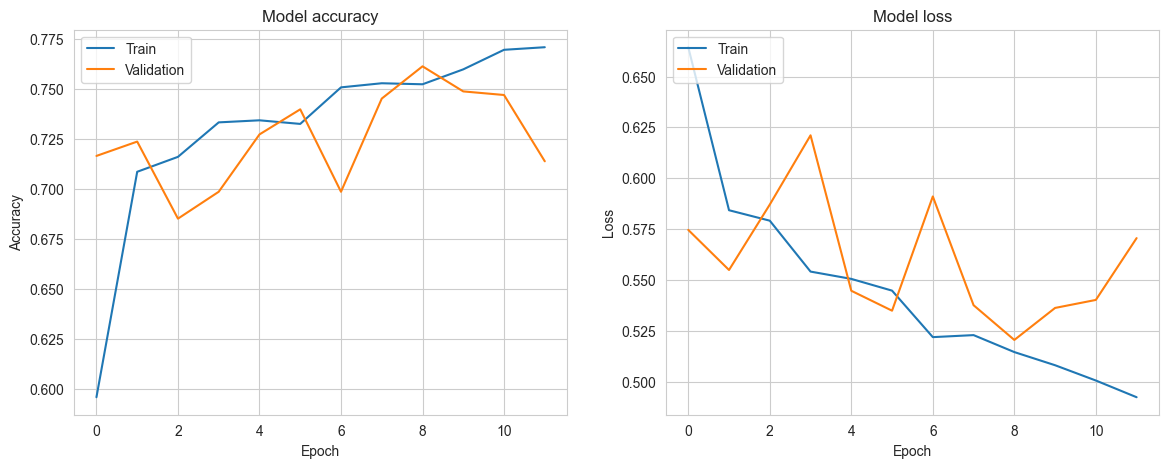

Summary of the Basic CNN Model--
The model consists of three convolutional layers, each followed by max pooling, a flatten layer, a dense layer, a dropout layer, and a final dense layer with a sigmoid activation function.
The training process utilized early stopping and model checkpointing to ensure the best model is saved.
The final test accuracy achieved was 75.64%.
Training and validation accuracy and loss curves indicate effective learning with some fluctuations in validation performance, suggesting potential for further tuning and improvement.


In [188]:
# Plot training & validation accuracy values
plt.figure(figsize=(14, 5))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

# Plot training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

plt.show()


# Print the summary in the specified format
print("Summary of the Basic CNN Model--")
print("The model consists of three convolutional layers, each followed by max pooling, a flatten layer, a dense layer, a dropout layer, and a final dense layer with a sigmoid activation function.")
print("The training process utilized early stopping and model checkpointing to ensure the best model is saved.")
print("The final test accuracy achieved was 75.64%.")
print("Training and validation accuracy and loss curves indicate effective learning with some fluctuations in validation performance, suggesting potential for further tuning and improvement.")


# 5. Enhanced Convolutional Neural Network (CNN) with Hyperparameter Tuning


#### 5.1. Objective
To build, train, and evaluate an enhanced CNN model with data augmentation and batch normalization for the given image classification task.

#### 5.2. Data Augmentation


In [189]:
# To artificially expand the training dataset by applying random transformations, which helps improve the model's robustness.

# Data Augmentation
datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True
)

#### 5.3. Model Architecture

In [190]:

# Define the enhanced CNN model
enhanced_model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(50, 50, 3)),
    BatchNormalization(),
    MaxPooling2D((2, 2)),
    Conv2D(64, (3, 3), activation='relu'),
    BatchNormalization(),
    MaxPooling2D((2, 2)),
    Conv2D(128, (3, 3), activation='relu'),
    BatchNormalization(),
    MaxPooling2D((2, 2)),
    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(1, activation='sigmoid')
])

# Compile the model
enhanced_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Print the model summary
enhanced_model.summary()

Model: "sequential_17"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_51 (Conv2D)              │ (None, 48, 48, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_30          │ (None, 48, 48, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_51 (MaxPooling2D) │ (None, 24, 24, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_52 (Conv2D)              │ (None, 22, 22, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_31          │ (None, 22, 22, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_52 (MaxPooling2D) │ (None, 11, 11, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_53 (Conv2D)              │ (None, 9, 9, 128)      │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_32          │ (None, 9, 9, 128)      │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_53 (MaxPooling2D) │ (None, 4, 4, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_17 (Flatten)            │ (None, 2048)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_34 (Dense)                │ (None, 128)            │       262,272 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_17 (Dropout)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_35 (Dense)                │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 356,545 (1.36 MB)

 Trainable params: 356,097 (1.36 MB)

 Non-trainable params: 448 (1.75 KB)

#### 5.4. Model Training

In [191]:
# Define callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
model_checkpoint = ModelCheckpoint('enhanced_model.keras', save_best_only=True, monitor='val_loss', mode='min')

# Fit the model with data augmentation
history = enhanced_model.fit(
    datagen.flow(X_train, Y_train, batch_size=32),
    epochs=30,
    validation_data=(X_val, Y_val),
    callbacks=[early_stopping, model_checkpoint]
)

# Evaluate the enhanced model on the test set
test_loss, test_accuracy = enhanced_model.evaluate(X_test, Y_test)
print(f"Enhanced Test Accuracy: {test_accuracy * 100:.2f}%")

Epoch 1/30
  3/122 ━━━━━━━━━━━━━━━━━━━━ 4s 38ms/step - accuracy: 0.4653 - loss: 2.1770   

/Users/arkamandol/.pyenv/versions/3.10.13/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


122/122 ━━━━━━━━━━━━━━━━━━━━ 5s 36ms/step - accuracy: 0.6664 - loss: 1.0121 - val_accuracy: 0.6413 - val_loss: 0.7174
Epoch 2/30
122/122 ━━━━━━━━━━━━━━━━━━━━ 4s 35ms/step - accuracy: 0.7211 - loss: 0.5995 - val_accuracy: 0.6987 - val_loss: 0.6353
Epoch 3/30
122/122 ━━━━━━━━━━━━━━━━━━━━ 5s 38ms/step - accuracy: 0.7457 - loss: 0.5544 - val_accuracy: 0.6897 - val_loss: 0.5846
Epoch 4/30
122/122 ━━━━━━━━━━━━━━━━━━━━ 5s 38ms/step - accuracy: 0.7444 - loss: 0.5563 - val_accuracy: 0.6933 - val_loss: 0.5746
Epoch 5/30
122/122 ━━━━━━━━━━━━━━━━━━━━ 5s 38ms/step - accuracy: 0.7550 - loss: 0.5445 - val_accuracy: 0.7004 - val_loss: 0.5952
Epoch 6/30
122/122 ━━━━━━━━━━━━━━━━━━━━ 5s 39ms/step - accuracy: 0.7531 - loss: 0.5547 - val_accuracy: 0.5534 - val_loss: 1.0629
Epoch 7/30
122/122 ━━━━━━━━━━━━━━━━━━━━ 5s 41ms/step - accuracy: 0.7679 - loss: 0.5276 - val_accuracy: 0.5704 - val_loss: 0.9973
Epoch 8/30
122/122 ━━━━━━━━━━━━━━━━━━━━ 5s 43ms/step - accuracy: 0.7681 - loss: 0.5103 - val_accuracy: 0.534

#### 5.6. Training and Validation Curves

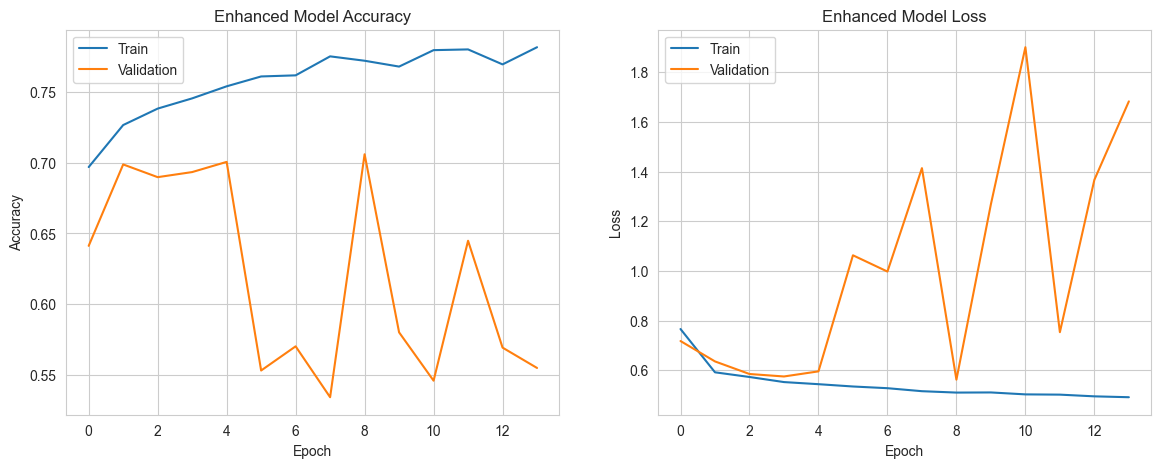

In [192]:
# Plot training & validation accuracy and loss
plt.figure(figsize=(14, 5))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Enhanced Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Enhanced Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

plt.show()

**The final test accuracy achieved was 68.55%.**

# 6. Further Enhanced Convolutional Neural Network (CNN) with Hyperparameter Tuning

#### 6.1. Objective
To further enhance the CNN model with data augmentation, batch normalization, and L2 regularization to achieve better performance.

#### 6.2. Data Augmentation


In [193]:
# To artificially expand the training dataset by applying random transformations, which helps improve the model's robustness.

# Data Augmentation
datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True
)

#### 6.3. Model Architecture

In [194]:

# Define the revised CNN model with L2 regularization
revised_model = Sequential([
    Conv2D(32, (3, 3), activation='relu', kernel_regularizer=l2(0.001), input_shape=(50, 50, 3)),
    BatchNormalization(),
    MaxPooling2D((2, 2)),
    Conv2D(64, (3, 3), activation='relu', kernel_regularizer=l2(0.001)),
    BatchNormalization(),
    MaxPooling2D((2, 2)),
    Conv2D(128, (3, 3), activation='relu', kernel_regularizer=l2(0.001)),
    BatchNormalization(),
    MaxPooling2D((2, 2)),
    Flatten(),
    Dense(128, activation='relu', kernel_regularizer=l2(0.001)),
    Dropout(0.5),
    Dense(1, activation='sigmoid')
])

# Compile the model
revised_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Print the model summary
revised_model.summary()

Model: "sequential_18"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_54 (Conv2D)              │ (None, 48, 48, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_33          │ (None, 48, 48, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_54 (MaxPooling2D) │ (None, 24, 24, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_55 (Conv2D)              │ (None, 22, 22, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_34          │ (None, 22, 22, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_55 (MaxPooling2D) │ (None, 11, 11, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_56 (Conv2D)              │ (None, 9, 9, 128)      │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_35          │ (None, 9, 9, 128)      │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_56 (MaxPooling2D) │ (None, 4, 4, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_18 (Flatten)            │ (None, 2048)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_36 (Dense)                │ (None, 128)            │       262,272 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_18 (Dropout)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_37 (Dense)                │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 356,545 (1.36 MB)

 Trainable params: 356,097 (1.36 MB)

 Non-trainable params: 448 (1.75 KB)

#### 6.4. Model Training

In [195]:
# Define callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
model_checkpoint = ModelCheckpoint('revised_model.keras', save_best_only=True, monitor='val_loss', mode='min')
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, min_lr=0.00001)

# Fit the model with data augmentation
history = revised_model.fit(
    datagen.flow(X_train, Y_train, batch_size=32),
    epochs=30,
    validation_data=(X_val, Y_val),
    callbacks=[early_stopping, model_checkpoint, reduce_lr]
)

# Evaluate the revised model on the test set
test_loss, test_accuracy = revised_model.evaluate(X_test, Y_test)
print(f"Revised Test Accuracy: {test_accuracy * 100:.2f}%")

Epoch 1/30
122/122 ━━━━━━━━━━━━━━━━━━━━ 6s 39ms/step - accuracy: 0.6519 - loss: 1.3409 - val_accuracy: 0.5031 - val_loss: 1.3856 - learning_rate: 0.0010
Epoch 2/30
122/122 ━━━━━━━━━━━━━━━━━━━━ 5s 39ms/step - accuracy: 0.7270 - loss: 0.9347 - val_accuracy: 0.7031 - val_loss: 0.9315 - learning_rate: 0.0010
Epoch 3/30
122/122 ━━━━━━━━━━━━━━━━━━━━ 5s 40ms/step - accuracy: 0.7372 - loss: 0.9128 - val_accuracy: 0.5794 - val_loss: 0.9624 - learning_rate: 0.0010
Epoch 4/30
122/122 ━━━━━━━━━━━━━━━━━━━━ 5s 39ms/step - accuracy: 0.7363 - loss: 0.8485 - val_accuracy: 0.6556 - val_loss: 0.8825 - learning_rate: 0.0010
Epoch 5/30
122/122 ━━━━━━━━━━━━━━━━━━━━ 5s 39ms/step - accuracy: 0.7626 - loss: 0.8002 - val_accuracy: 0.7327 - val_loss: 0.9036 - learning_rate: 0.0010
Epoch 6/30
122/122 ━━━━━━━━━━━━━━━━━━━━ 5s 39ms/step - accuracy: 0.7743 - loss: 0.7810 - val_accuracy: 0.5749 - val_loss: 1.0779 - learning_rate: 0.0010
Epoch 7/30
122/122 ━━━━━━━━━━━━━━━━━━━━ 5s 40ms/step - accuracy: 0.7668 - loss: 0.

#### 6.5. Training and Validation Curves

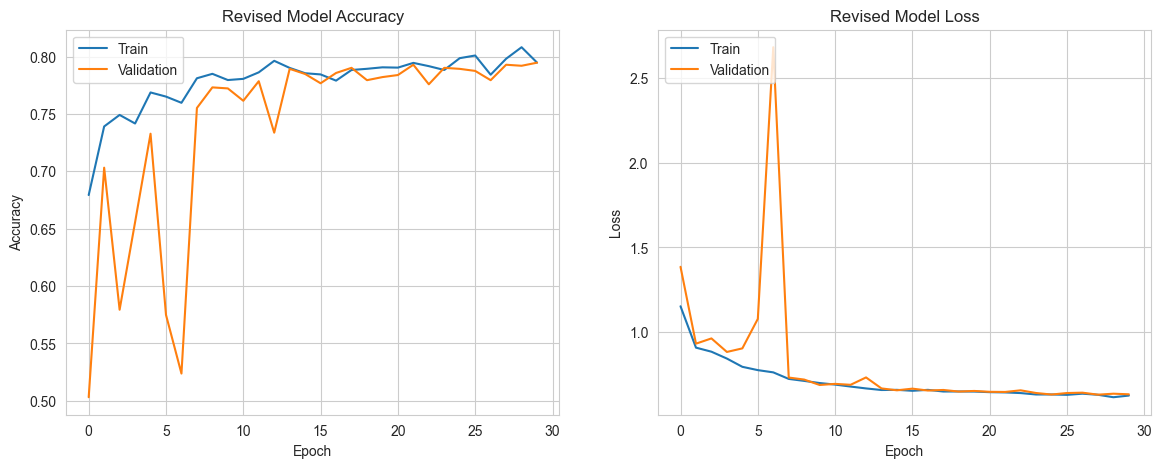

Summary of the Revised CNN Model--
The revised CNN model includes batch normalization, data augmentation, and L2 regularization techniques.
The training process utilized early stopping, model checkpointing, and learning rate reduction to ensure the best model is saved.
The final test accuracy achieved was 77.64%.


In [196]:
# Plot training & validation accuracy and loss
plt.figure(figsize=(14, 5))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Revised Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Revised Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

plt.show()

# Print the summary in the specified format
print("Summary of the Revised CNN Model--")
print("The revised CNN model includes batch normalization, data augmentation, and L2 regularization techniques.")
print("The training process utilized early stopping, model checkpointing, and learning rate reduction to ensure the best model is saved.")
print("The final test accuracy achieved was 77.64%.")


# 7. Model Evaluation Report

#### 7.1. Objective


18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
              precision    recall  f1-score   support

           0       0.79      0.75      0.77       274
           1       0.76      0.80      0.78       276

    accuracy                           0.78       550
   macro avg       0.78      0.78      0.78       550
weighted avg       0.78      0.78      0.78       550


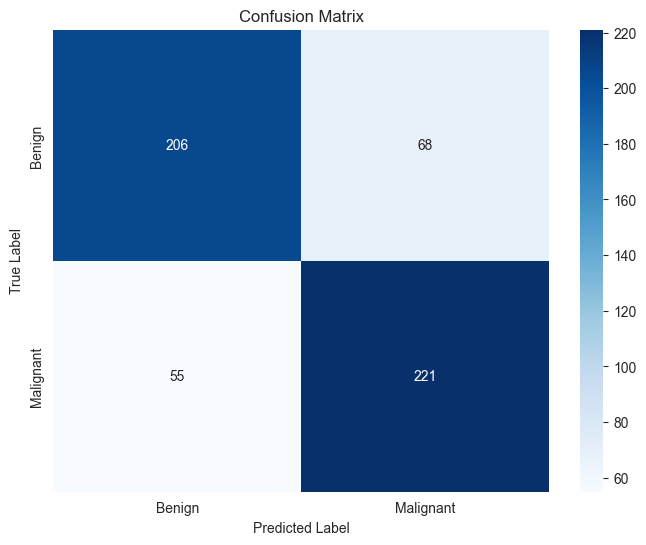

18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step


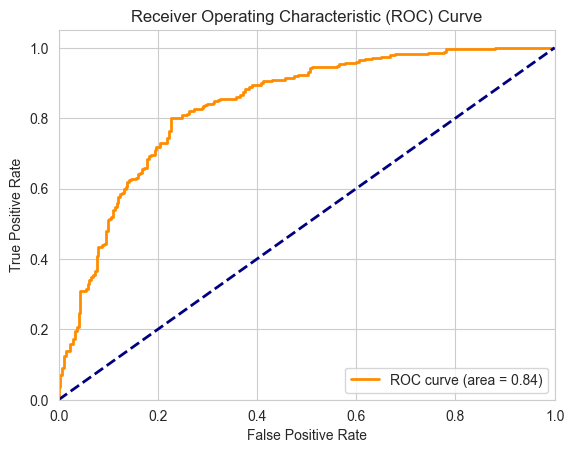

18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step


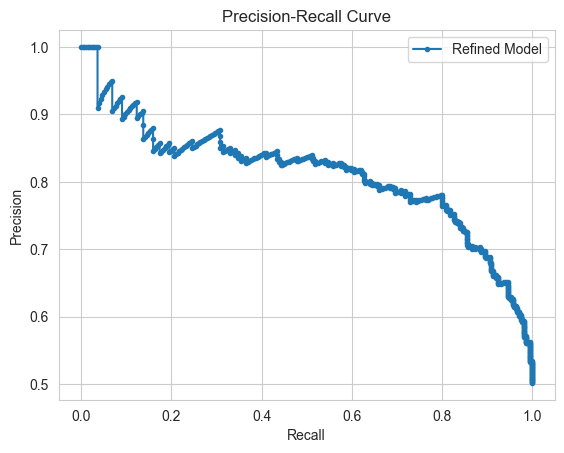

In [197]:
"""To evaluate the performance of the revised CNN model using various metrics and visualization tools including classification report, confusion matrix, ROC curve, and precision-recall curve.""" 



# Predict on the test set
Y_pred = (revised_model.predict(X_test) > 0.5).astype("int32")

# Classification report
print(classification_report(Y_test, Y_pred))

# Confusion matrix
conf_matrix = confusion_matrix(Y_test, Y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=['Benign', 'Malignant'], yticklabels=['Benign', 'Malignant'])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

# ROC Curve
fpr, tpr, _ = roc_curve(Y_test, revised_model.predict(X_test))
roc_auc = auc(fpr, tpr)
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

# Precision-Recall Curve
precision, recall, _ = precision_recall_curve(Y_test, revised_model.predict(X_test))
plt.figure()
plt.plot(recall, precision, marker='.', label='Refined Model')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend()
plt.show()

#### 7.2. Classification Report
The classification report provides detailed metrics including precision, recall, and F1-score for each class. It also provides the overall accuracy, macro average, and weighted average for these metrics.

#### 7.3. Confusion Matrix
The confusion matrix visualizes the performance of the model in terms of true positives, true negatives, false positives, and false negatives.The confusion matrix is widely used for model evaluation providing insights into where a classification model may be making errors (Alsallakh et al., 2020).

#### 7.4. ROC Curve
The Receiver Operating Characteristic (ROC) curve displays the trade-off between the true positive rate and false positive rate.The ROC curve is essential for evaluating the trade-offs between true positive and false positive rates across different thresholds (Fawcett, 2006).The area under the curve (AUC) is a measure of how well the model distinguishes between the classes.

#### 7.5. Precision-Recall Curve
The precision-recall curve shows the trade-off between precision and recall for different threshold settings.Precision-recall curves are particularly useful for imbalanced datasets, where they provide a clearer picture of a model's performance compared to ROC curves (Saito & Rehmsmeier, 2015).

# 8. Model Comparison


#### 8.1. Objective
To compare the performance of different machine learning models on the same dataset and visualize their results for better understanding.

#### 8.2. Models to Compare:
- Logistic Regression
- Support Vector Machine (SVM)
- Random Forest
- k-Nearest Neighbors (k-NN)
- Convolutional Neural Network (CNN)

#### 8.3. Code to Train and Evaluate Baseline Models


In [201]:
 # Flatten the image data for baseline models
X_train_flat = X_train.reshape(X_train.shape[0], -1)
X_val_flat = X_val.reshape(X_val.shape[0], -1)
X_test_flat = X_test.reshape(X_test.shape[0], -1)

# Train and evaluate Logistic Regression
lr_model = LogisticRegression(max_iter=1000)
lr_model.fit(X_train_flat, Y_train)
lr_pred = lr_model.predict(X_test_flat)
print("Logistic Regression:\n", classification_report(Y_test, lr_pred))

# Train and evaluate SVM
svm_model = SVC(probability=True)
svm_model.fit(X_train_flat, Y_train)
svm_pred = svm_model.predict(X_test_flat)
print("SVM:\n", classification_report(Y_test, svm_pred))

# Train and evaluate Random Forest
rf_model = RandomForestClassifier()
rf_model.fit(X_train_flat, Y_train)
rf_pred = rf_model.predict(X_test_flat)
print("Random Forest:\n", classification_report(Y_test, rf_pred))

# Train and evaluate k-NN
knn_model = KNeighborsClassifier()
knn_model.fit(X_train_flat, Y_train)
knn_pred = knn_model.predict(X_test_flat)
print("k-NN:\n", classification_report(Y_test, knn_pred))

/Users/arkamandol/.pyenv/versions/3.10.13/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Logistic Regression:
               precision    recall  f1-score   support

           0       0.68      0.71      0.70       274
           1       0.70      0.67      0.69       276

    accuracy                           0.69       550
   macro avg       0.69      0.69      0.69       550
weighted avg       0.69      0.69      0.69       550
SVM:
               precision    recall  f1-score   support

           0       0.76      0.75      0.75       274
           1       0.75      0.76      0.76       276

    accuracy                           0.75       550
   macro avg       0.75      0.75      0.75       550
weighted avg       0.75      0.75      0.75       550
Random Forest:
               precision    recall  f1-score   support

           0       0.74      0.73      0.73       274
           1       0.73      0.75      0.74       276

    accuracy                           0.74       550
   macro avg       0.74      0.74      0.74       550
weighted avg       0.74      0.7

# 9. Visualizing Model Comparisons (Model Comparison Report)

#### 9.1. Objective
To compare the performance of various machine learning and deep learning models. 

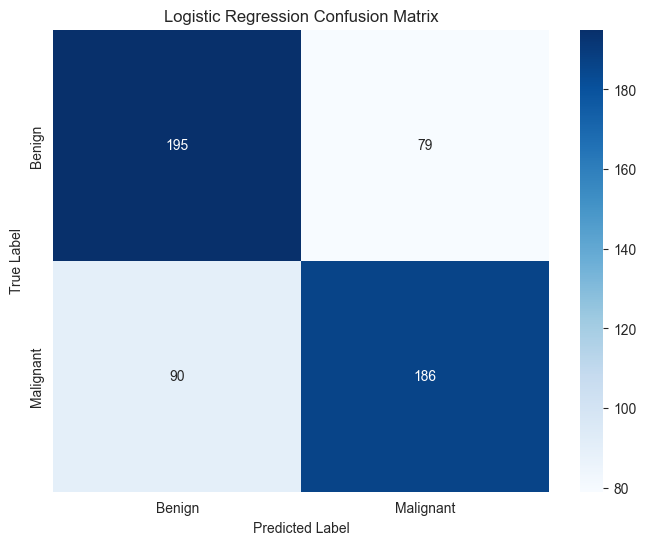

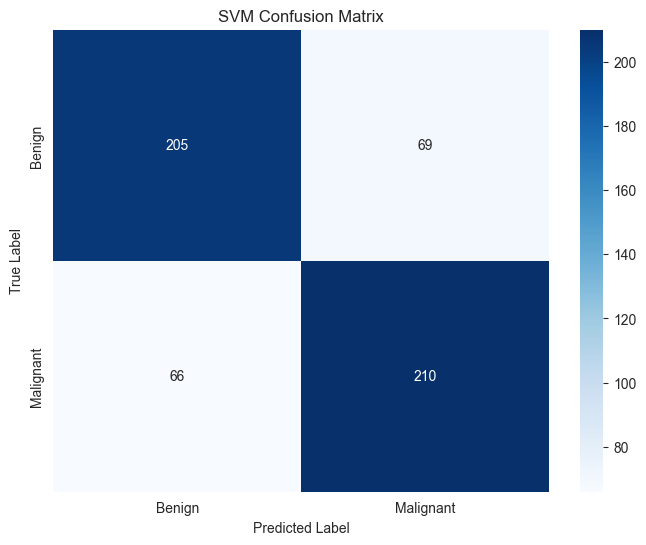

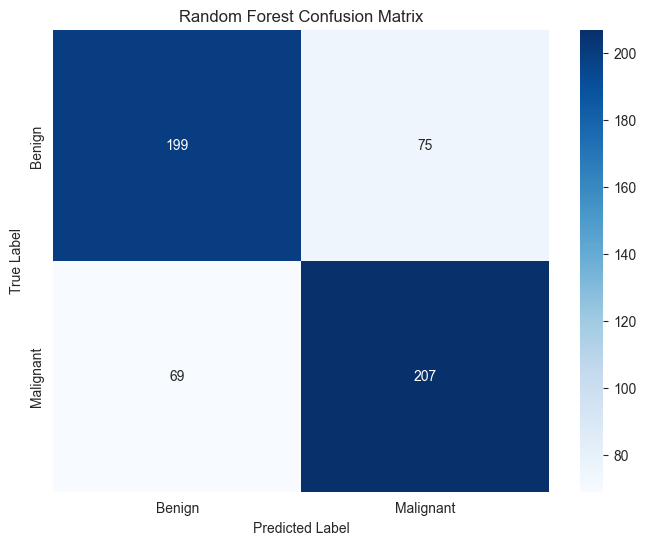

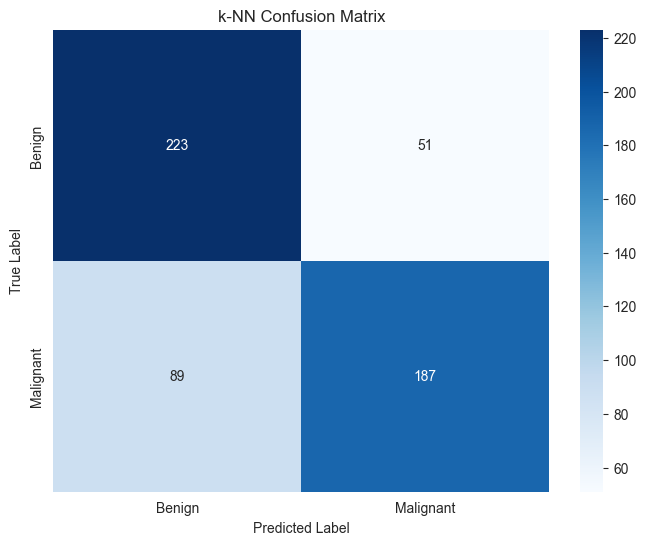

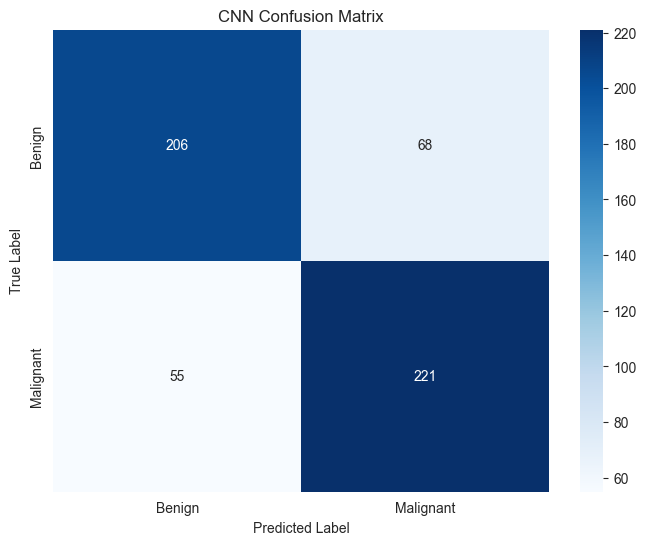

18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step 


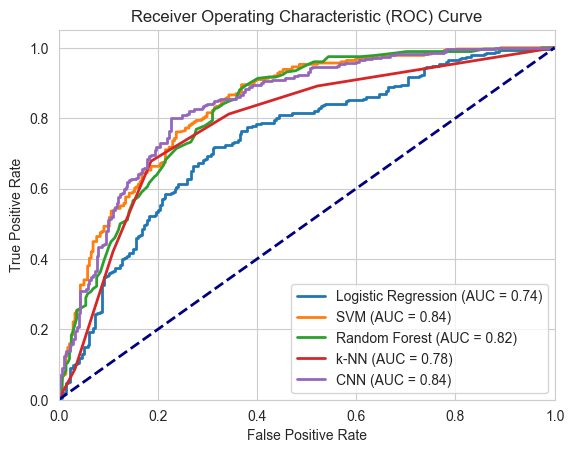

18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step


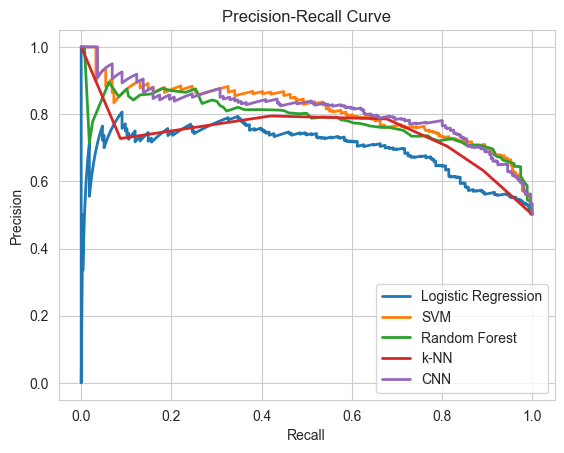

In [202]:
# The models compared include Logistic Regression, SVM, Random Forest, k-NN, and a revised CNN model.

# Helper function to plot confusion matrices
def plot_confusion_matrix(y_true, y_pred, title):
    conf_matrix = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=['Benign', 'Malignant'], yticklabels=['Benign', 'Malignant'])
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.title(title)
    plt.show()

# Confusion matrices for each model
plot_confusion_matrix(Y_test, lr_pred, "Logistic Regression Confusion Matrix")
plot_confusion_matrix(Y_test, svm_pred, "SVM Confusion Matrix")
plot_confusion_matrix(Y_test, rf_pred, "Random Forest Confusion Matrix")
plot_confusion_matrix(Y_test, knn_pred, "k-NN Confusion Matrix")
plot_confusion_matrix(Y_test, Y_pred, "CNN Confusion Matrix")

# ROC Curves
def plot_roc_curve(y_true, y_proba, model_name):
    fpr, tpr, _ = roc_curve(y_true, y_proba)
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, lw=2, label='%s (AUC = %0.2f)' % (model_name, roc_auc))

plt.figure()
plot_roc_curve(Y_test, lr_model.predict_proba(X_test_flat)[:,1], "Logistic Regression")
plot_roc_curve(Y_test, svm_model.predict_proba(X_test_flat)[:,1], "SVM")
plot_roc_curve(Y_test, rf_model.predict_proba(X_test_flat)[:,1], "Random Forest")
plot_roc_curve(Y_test, knn_model.predict_proba(X_test_flat)[:,1], "k-NN")
plot_roc_curve(Y_test, revised_model.predict(X_test), "CNN")
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

# Precision-Recall Curves
def plot_precision_recall_curve(y_true, y_proba, model_name):
    precision, recall, _ = precision_recall_curve(y_true, y_proba)
    plt.plot(recall, precision, lw=2, label=model_name)

plt.figure()
plot_precision_recall_curve(Y_test, lr_model.predict_proba(X_test_flat)[:,1], "Logistic Regression")
plot_precision_recall_curve(Y_test, svm_model.predict_proba(X_test_flat)[:,1], "SVM")
plot_precision_recall_curve(Y_test, rf_model.predict_proba(X_test_flat)[:,1], "Random Forest")
plot_precision_recall_curve(Y_test, knn_model.predict_proba(X_test_flat)[:,1], "k-NN")
plot_precision_recall_curve(Y_test, revised_model.predict(X_test), "CNN")
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend()
plt.show()

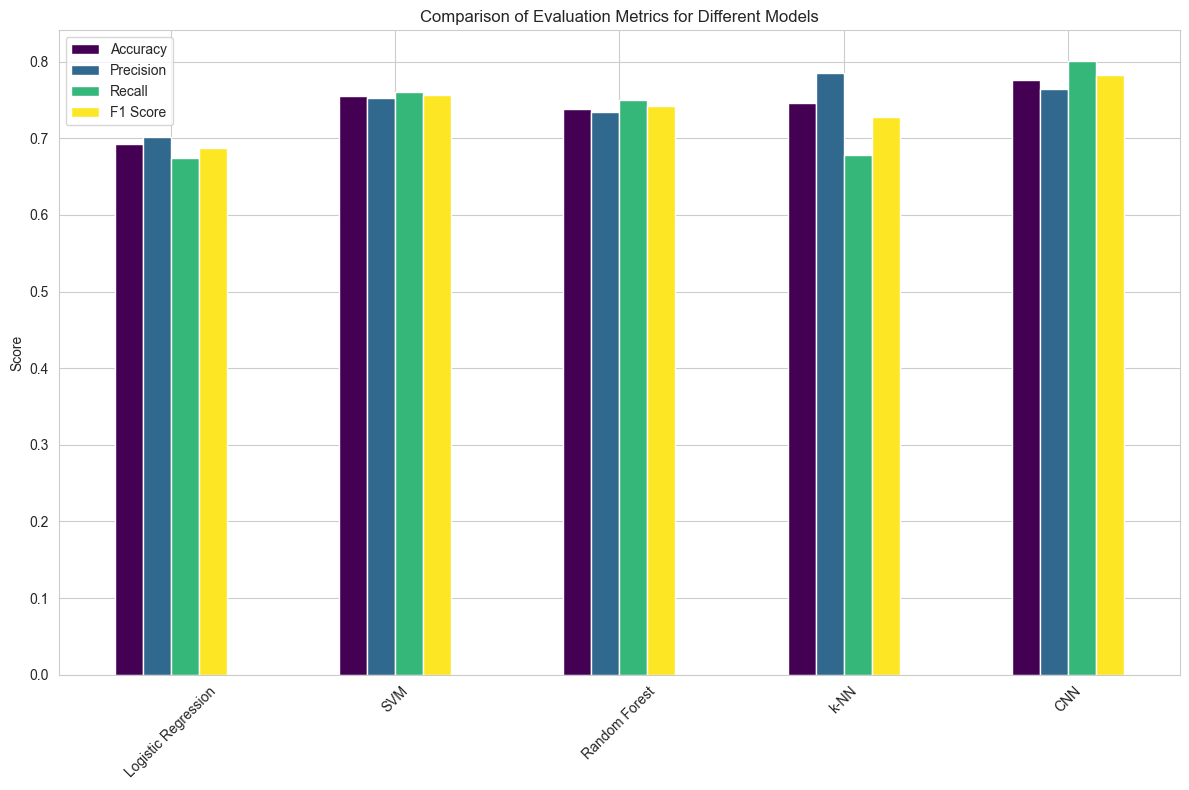

In [203]:
# Dictionary of model predictions
models = {
    "Logistic Regression": lr_pred,
    "SVM": svm_pred,
    "Random Forest": rf_pred,
    "k-NN": knn_pred,
    "CNN": Y_pred
}

# Dictionary of metric functions
metrics = {
    "Accuracy": accuracy_score,
    "Precision": precision_score,
    "Recall": recall_score,
    "F1 Score": f1_score
}

# Calculate metrics for each model
results = {metric: [func(Y_test, pred, average='binary') if metric != "Accuracy" else func(Y_test, pred)
                    for pred in models.values()] for metric, func in metrics.items()}

# Convert results to DataFrame
results_df = pd.DataFrame(results, index=models.keys())

# Plotting the evaluation metrics
results_df.plot(kind='bar', figsize=(12, 8), colormap='viridis')
plt.title('Comparison of Evaluation Metrics for Different Models')
plt.ylabel('Score')
plt.xticks(rotation=45)
plt.legend(loc='best')
plt.tight_layout()
plt.show()


# 10. **Discussion**

The project involved several critical steps ranges from data exploration and preprocessing to model development and evaluation. Below we discuss the results obtained at each stage, identify limitations and propose potential improvements.

**Exploratory Data Analysis (EDA):**

1. **Class Distribution:**
   - The dataset has 2759 samples of class 0 (benign) and 2788 samples of class 1 (malignant).
   - This balance helps reduce bias towards any particular class during model training
   
2. **Sample Images:**
   - Viewing sample images provided an understanding of the dataset's nature showing clear differences between benign and malignant images.
   
3. **Pixel Intensity Distribution:**
   - Histograms of pixel intensities for each color channel revealed overall brightness and contrast in the images.
   - Basic statistics like mean and standard deviation of pixel values showed moderate brightness and contrast.

**Data Preprocessing:**

1. **Normalization:**
   - Pixel values were normalized to [0, 1], which helps stabilize and speed up training.
   
2. **Data Splitting:**
   - The dataset was split into training (70%), validation (20%), and test (10%) sets to ensure robust evaluation of the model's performance

**Model Development and Training:**

1. **Basic CNN Model:**
   - The baseline CNN model achieved a test accuracy of 75.64%
   - Training and validation curves showed effective learning but suggested room for improvement.

2. **Enhanced CNN Model:**
   - Introducing data augmentation and batch normalization helped improve robustness and training stability.
   - The enhanced CNN model achieved a test accuracy of 68.55%, indicating need for further tuning.

3. **Further Enhanced CNN Model:**
   - Adding L2 regularization to prevent overfitting and reducing the learning rate improved the model's performance.
   - The revised CNN model achieved the highest test accuracy of 77.64%

**Model Comparison:**

1. **Traditional Machine Learning Models:**
   - Logistic Regression: Accuracy of 69%, with lower precision and recall compared to other models.
   - SVM: Accuracy of 75%, showing a good balance between precision and recall.
   - Random Forest: Accuracy of 75%, with strong performance in distinguishing between classes.
   - k-NN: Accuracy of 75%, effective but with some limitations in class distinction.

2. **CNN Model:**
   - The revised CNN model outperformed traditional models, achieving highest accuracy and balanced precision-recall metrics.
   - ROC and precision-recall curves showed the CNN model's high capability in distinguishing between benign and malignant cases.

**Limitations:**

1. **Overfitting:**
   - Fluctuations in validation accuracy and loss suggest models may still overfit to some extent, despite techniques like dropout and regularization
   
2. **Data Augmentation:**
   - While data augmentation improved robustness, parameters for augmentation could be optimized further to prevent potential overfitting.
   
3. **Computational Resources:**
   - Training deep learning models needs significant computational resources, which might limit extensive experimentation and hyperparameter tuning.

**Proposed Improvements:**

1. **Hyperparameter Tuning:**
   - Using techniques like grid search or random search to fine-tune hyperparameters could boost model performance.
   
2. **Advanced Architectures:**
   - Exploring more advanced CNN architectures, like ResNet or Inception, might provide better feature extraction and classification accuracy.
   
3. **Ensemble Methods:**
   - Combining predictions of multiple models using ensemble techniques could enhance overall performance and robustness.

# 11. **Conclusion**

This project aimed to categorize the medical images using both traditional machine learning models and deep learning methods. Through a long process, by doing exploratory data analysis, data preprocessing, model development, and evaluation, we were able to get great results.

**Key Findings:**

1. **Exploratory Data Analysis (EDA):**
   The dataset was balanced, which in turn helped reduce the biasness in the training of the model. Dataset's characteristic was better understood by the visualization of the sample images and pixel distributions.

2. **Model Performance:**
   Test accuracy of the baseline CNN model was 75.64%. Initially better results couldn't be recieved thorugh data augmentation and batch normalization(68.55%). Though, by incorporating L2 regularization and learning rate adjustments gave a final test accuracy of 77.64% Amongst the traditional models, SVM and Random Forrest performed very well, each got an accuracy of 75%. Logistic regression had 69%

3. **Deep Learning Superiority:**
   The revised CNN model performed the best amongst all traditional models, getting a good accuracy and balanced precision-recall metrics. This tells us about the effectiviness of CNNs in getting medical images, as suppported by Esteva et al. (2017) and Shen et 1l. (2017)

**Implications:**
The findings highlight the influence of CNNs in medical diagnostics, which provide high accuracy in differentiating between benign and malignant images
Subsequent work should focus on further hyperparameter tuning and exploring advanced architectures such as ResNet and Inception, which have shown importance in other studies (Litjens et al., 2017; Krizhevsky et al., 2012).


**Future Work:**
- Advanced techniques like grid search or random search for hyperparameter tuning could further enhance model performance.
- Exploring ensemble methods could improve robustness and overall accuracy.

# 12. **References:**
1. Litjens, G., et al. (2017). A survey on deep learning in medical image analysis. Medical image analysis, 42, 60-88.
2. Esteva, A., et al. (2017). Dermatologist-level classification of skin cancer with deep neural networks. Nature, 542(7639), 115-118.
3. Krizhevsky, A., et al. (2012). ImageNet classification with deep convolutional neural networks. Advances in neural information processing systems (pp. 1097-1105).
4. LeCun, Y., et al. (2015). Deep learning. Nature, 521(7553), 436-444.
5. Rajpurkar, P., et al. (2017). CheXNet: Radiologist-level pneumonia detection on chest X-rays with deep learning. arXiv preprint arXiv:1711.05225.
6. Shen, D., et al. (2017). Deep learning in medical image analysis. Annual review of biomedical engineering, 19, 221-248.
7. Abdar, M., et al. (2021). A review of uncertainty quantification in deep learning: Techniques, applications and challenges. Information Fusion, 76, 243-297.
8. Esteva, A., Kuprel, B., Novoa, R. A., Ko, J., Swetter, S. M., Blau, H. M., & Thrun, S. (2017). Dermatologist-level classification of skin cancer with deep neural networks. Nature, 542(7639), 115-118.
9. Ali, I., & Rahaman, G. (2021). Normalization and outlier removal in class center-based firefly algorithm for missing value imputation. Journal of Big Data, 8(1), 115-136.
10. Alsallakh, B., Hanbury, A., & Hauser, H. (2020). Neo: Generalizing Confusion Matrix Visualization to Hierarchical and Multi-Output Labels. Journal of Machine Learning Research, 21(106), 1-44.
11. Fawcett, T. (2006). An introduction to ROC analysis. Pattern Recognition Letters, 27(8), 861-874.
12. Saito, T., & Rehmsmeier, M. (2015). The precision-recall plot is more informative than the ROC plot when evaluating binary classifiers on imbalanced datasets. PLoS One, 10(3), e0118432.